In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
N=500
m=2#亚组
P=1#一维
weight=[0.4,0.6]
mean=[-1.5,1.5]
covs=[1,0.6]#标准差
Theta=np.array([weight,mean,covs])
Theta#混合高斯分布的参数，mean越靠近且离散程度越大，区分的难度越大
p1=int(N*weight[0])
p2=int(N*weight[1])

In [3]:
np.random.seed(12)
x=np.random.normal(0,3,N)
betat=np.random.uniform(0,1,P)
betat

array([0.2681622])

In [4]:
np.random.seed(123)
aa=np.random.normal(mean[0],covs[0],p1)
bb=np.random.normal(mean[1],covs[1],p2)
gamma=np.zeros((N,2))#随机效应的具体取值，第二列为所属亚组
gamma[:,0]=np.hstack((aa,bb))
gamma[:p1,1]=0
gamma[-p2:,1]=1

In [5]:
y=np.zeros((N,2))
for i in range(N):
        y[i,0]=np.dot(x[i],betat)+gamma[i,0]
        y[i,1]=gamma[i,1]

In [6]:
coef=st.linregress(x, y[:,0])[0] # 斜率
intercept = st.linregress(x, y[:,0])[1] # 截距
print(coef, intercept) # 输出斜率和截距

0.31541486724771184 0.28670038145510324


In [7]:
print(betat)

[0.2681622]


In [8]:
data0=np.zeros(N)
for i in range(N):
    data0[i]=y[i,0]-np.dot(x[i],coef)

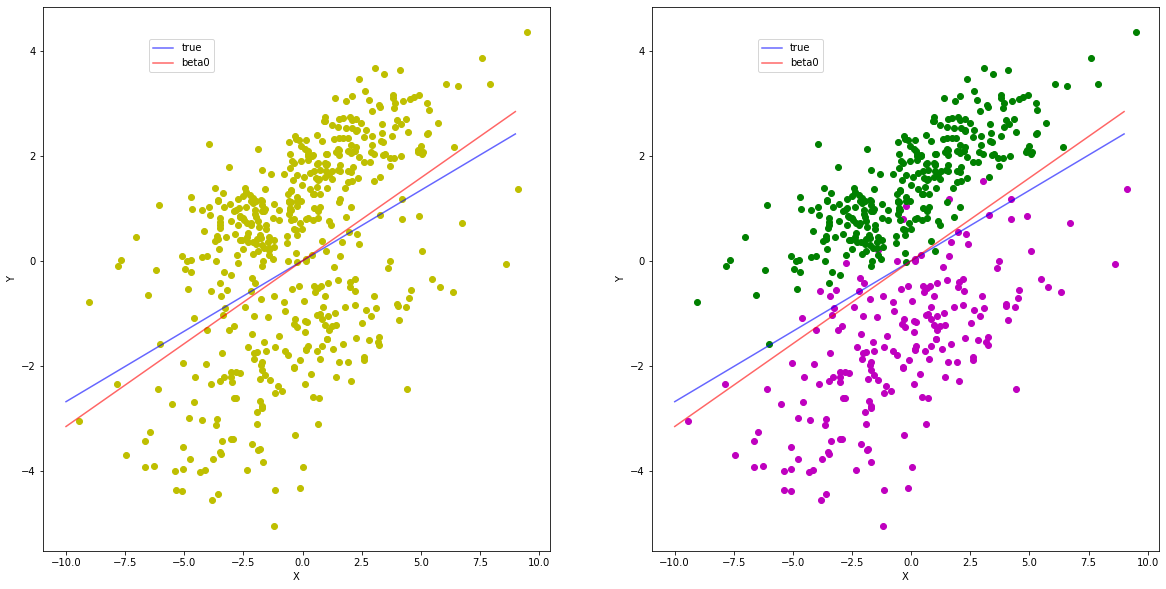

In [18]:
fig = plt.figure(figsize=(20,10))

X=np.arange(-10,10)
y11=betat*X
y12=coef*X

ax1 = fig.add_subplot(122)
ax1.plot(X,y11, color='b',alpha=0.6,label="true")
ax1.plot(X,y12, color='r',alpha=0.6,label="beta0")
ax1.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
ax1.scatter(x[:p1], y[:p1,0], c='m')  # 绘制数据点
ax1.scatter(x[-p2:], y[-p2:,0], c='g')
ax1.set_ylabel('Y')  # 坐标轴
ax1.set_xlabel('X')

ax2 = fig.add_subplot(121)
ax2.plot(X,y11, color='b',alpha=0.6,label="true")
ax2.plot(X,y12, color='r',alpha=0.6,label="beta0")
ax2.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
ax2.scatter(x, y[:,0], c='y')  # 绘制数据点
ax2.set_ylabel('Y')  # 坐标轴
ax2.set_xlabel('X')

plt.show()

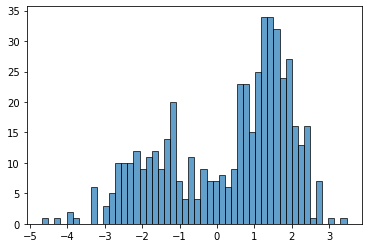

In [10]:
plt.hist(data0, bins=50,edgecolor="black", alpha=0.7)
plt.show()

In [11]:
smean=np.mean(data0)
sstd=np.std(data0)
ssvar=np.var(data0)
stheta0=np.array([smean,sstd])
stheta0#样本均值与样本的标准差

array([0.28670038, 1.64992442])

In [61]:
#假设通过某些方法得到一个较好的初值
beta0=coef
weight0=[0.5,0.5]
mean0=[-2,1]
covs0=[1,1]
theta0=np.array([weight0,mean0,covs0])

In [20]:
def normal(x,theta):
    mu=theta[0]
    s=theta[1]#标准差
    result=(1/(np.sqrt(2*np.pi)*s))*np.exp(-1*(x-mu)**2/(2*s**2))
    return result

In [25]:
def Lih(X,theta):
    num=X.shape[0]
    C=theta.shape[1]
    Ga=np.zeros((num,C))
    c=np.zeros(C)

    for j in range(num):#响应度
        for k in range(C):
            c[k]=theta[0,k]*normal(X[j],theta[1:,k])
        Ga[j]=c/np.sum(c)

    return Ga

In [45]:
def Betanxt(betanow,thetaold,Xs,Y,t=1):#定义了一个联系两次牛顿法迭代的函数
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betanow.T)
    L=Lih(data,thetaold)
    C=thetaold.shape[1]

    firstorder=0
    for h in range (C):
        for i in range(num):
            firstorder += (((L[i,h])/(thetaold[2,h]**2))*((data[i]-thetaold[1,h]))*(Xs[i]))

    secorder=0
    for h in range (C):
        for i in range(num):
            secorder += (((L[i,h])/(thetaold[2,h]**2))*((Xs[i])*(Xs[i])))


    invsecorder=1/(secorder)
    direction=np.dot(invsecorder,firstorder.T)
    λ2=np.dot(firstorder,direction)
    betanxt=betanow+t*direction
    return betanxt,λ2/2,t

In [46]:
print(beta0,'\n',betat)

0.31541486724771184 
 [0.2681622]


In [49]:
Betanxt(beta0,theta0,x,y[:,0],t=1)

(0.30072027090555414, 0.4936374483429148, 1)

In [50]:
def Betaout(betazero,thetazero,Xs,Y,t0=1.,ε=0.05,N=1000):#这里给了牛顿法一个循环上界N
    out=[betazero,100,t0]
    for i in range(N):
        out=Betanxt(out[0],thetazero,Xs,Y,out[2])
        if out[1]<=ε:
            break 
    return out,i+1

In [62]:
Betaout(beta0,theta0,x,y[:,0],t0=0.02,ε=0.02,N=1000)

((0.28944112389763665, 0.019874353104809273, 0.02), 144)